# **The Geometry of SAE Feature Structure: Galaxy Scale Exploration**

## **1. Download Gemma Scope SAE**

In [ ]:
!pip install transformers huggingface_hub

In [ ]:
!pip install sae_lens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 5.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.2/140.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.1/920.1 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.0 MB/s eta 0:00:00
   ━━━━

In [ ]:
!pip install torch

In [ ]:
import torch
print(torch.cuda.is_available())

False


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sae_lens import SAE
from transformers import AutoModel, AutoTokenizer

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform
from scipy.stats import binned_statistic
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.linalg import eigsh
import pickle
from sklearn.decomposition import PCA
from scipy.stats import linregress, t

/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


In [ ]:
!pip install powerlaw

In [ ]:
# Layer configuration as provided
layer_to_width_and_l0 = {
    0: ['65k', 73],
    1: ['65k', 121],
    2: ['65k', 77],
    3: ['65k', 89],
    4: ['65k', 89],
    5: ['65k', 105],
    6: ['65k', 107],
    7: ['65k', 107],
    8: ['65k', 111],
    9: ['65k', 118],
    10: ['65k', 128],
    11: ['65k', 70],
    12: ['65k', 72],
    13: ['65k', 75],
    14: ['65k', 73],
    15: ['65k', 127],
    16: ['65k', 128],
    17: ['65k', 125],
    18: ['65k', 116],
    19: ['65k', 115],
    20: ['65k', 114],
    21: ['65k', 111],
    22: ['65k', 116],
    23: ['65k', 123],
    24: ['65k', 124],
    25: ['65k', 93]
}

# Collect decoding vectors for all layers
all_decoding_vectors = []

# Iterate through the layers and load the corresponding SAE models
for layer, (width, l0) in layer_to_width_and_l0.items():
    sae_name = f"layer_{layer}/width_{width}/average_l0_{l0}"  # constructing SAE name
    try:
        sae, cfg_dict, sparsity = SAE.from_pretrained(  # load SAE model
            release=f"gemma-scope-2b-pt-res",
            sae_id=sae_name,
            device="cuda:0" if torch.cuda.is_available() else "cpu"
        )
        decoding_vectors = sae.W_dec  # accessing decoding vectors
        print(decoding_vectors.shape)  # e.g. (128, 1024)
        # all_decoding_vectors.append(decoding_vectors)
        print(f"Layer {layer}, Width {width}, l0 {l0}: {decoding_vectors.shape}")

        # Append decoding vectors to list for in-memory storage
        all_decoding_vectors.append((layer, decoding_vectors.cpu().detach().numpy()))

        # Save decoding vectors to a file named after the layer number
        filename = f"./Galaxy/decoding_vectors_layer_{layer}.npy"
        np.save(filename, decoding_vectors.cpu().detach().numpy())
        print(f"Saved decoding vectors for layer {layer} to {filename}")

    except RuntimeError as e:
        if 'out of memory' in str(e):
            print(f"OOM at layer {layer}:", e)
            # Add code to handle OOM, e.g., reduce batch size, use smaller model, etc.
            # For this example, we will skip the layer and continue
            continue
        else:
            raise e
    finally:
        # free up memory
        if 'sae' in locals(): # Check if sae is defined
            del sae
        if 'decoding_vectors' in locals(): #Check if decoding_vectors is defined
            del decoding_vectors
        torch.cuda.empty_cache()

# Save all_decoding_vectors using pickle
with open('./Galaxy/all_decoding_vectors.pkl', 'wb') as f:
    pickle.dump(all_decoding_vectors, f)

# Load the saved list of decoding vectors
with open('./Galaxy/all_decoding_vectors.pkl', 'rb') as f:
    all_decoding_vectors = pickle.load(f)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


params.npz:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

torch.Size([65536, 2304])
Layer 0, Width 65k, l0 73: torch.Size([65536, 2304])


FileNotFoundError: [Errno 2] No such file or directory: './Galaxy/decoding_vectors_layer_0.npy'

In [ ]:
# Define the list of layers we processed previously
layer_list = list(range(26))  # Process 26 layers
# layer_list_subset = [0, 4, 8, 12, 16, 20, 24]  # Process 7 layers

# Dictionary to hold the loaded feature vectors for each layer
all_decoding_features = {}

# Load the feature vectors for each layer
for layer in layer_list:  # layer_list_subset
    # filename = f"./Galaxy/decoding_vectors_layer_{layer}.npy"
    filename = f"/content/drive/MyDrive/Research/AI Interpretability/MIT-Teg/FeatureClustering/decoding_vectors_layer_{layer}.npy"
    try:
        decoding_vectors = np.load(filename)
        all_decoding_features[layer] = decoding_vectors
        print(f"Layer {layer} features loaded. Shaped: {decoding_vectors.shape}")
        print(f"Snippet of Layer {layer} features:\n {decoding_vectors[:5]}")  # Print the first 5 vectors
    except FileNotFoundError:
        print(f"File for layer {layer} not found. Skipping.")

Layer 0 features loaded. Shaped: (65536, 2304)
Snippet of Layer 0 features:
 [[ 0.00942899  0.03596718  0.01450018 ...  0.01245422 -0.01191416
  -0.01044037]
 [-0.0001087  -0.03335766  0.01283418 ... -0.00705172  0.0061024
  -0.00550912]
 [ 0.01665789 -0.02979554  0.02313105 ...  0.01500688  0.02631559
  -0.01026342]
 [ 0.00352073 -0.00359342 -0.00064668 ... -0.00844018 -0.04054294
   0.00289866]
 [ 0.00584867  0.00675517 -0.02862729 ...  0.0098827  -0.00383682
  -0.00090856]]
Layer 1 features loaded. Shaped: (65536, 2304)
Snippet of Layer 1 features:
 [[ 0.01617367  0.01724137 -0.01350248 ...  0.00574917 -0.0058237
  -0.01220389]
 [-0.02803173  0.0051062   0.00091282 ... -0.00612039 -0.04166316
   0.01230722]
 [ 0.00053928 -0.04304935 -0.01188961 ... -0.02699765  0.00225934
  -0.0347563 ]
 [ 0.01580276  0.00127208 -0.03489581 ... -0.01038833 -0.01846568
  -0.00307306]
 [ 0.00031879  0.00429484  0.0050806  ... -0.00334601 -0.0313086
  -0.01480182]]
Layer 2 features loaded. Shaped: (655

## 2. 3D Point Cloud Visualizations of Top PCA Components

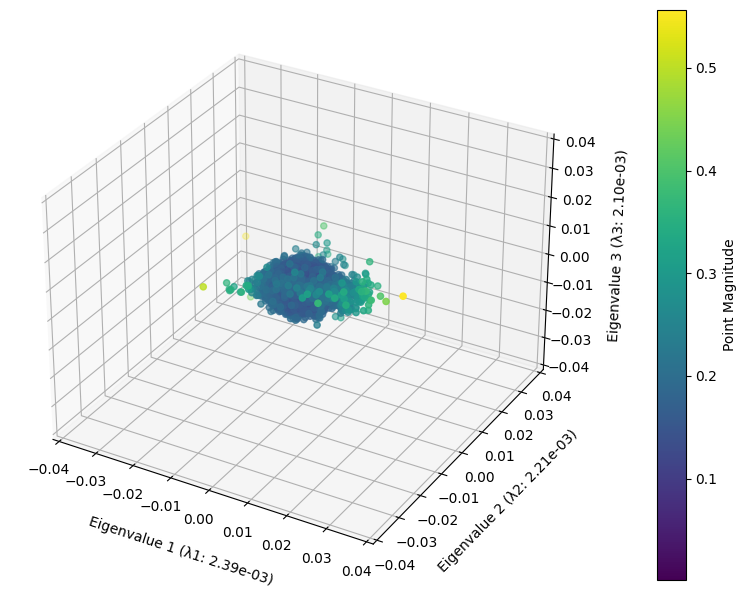

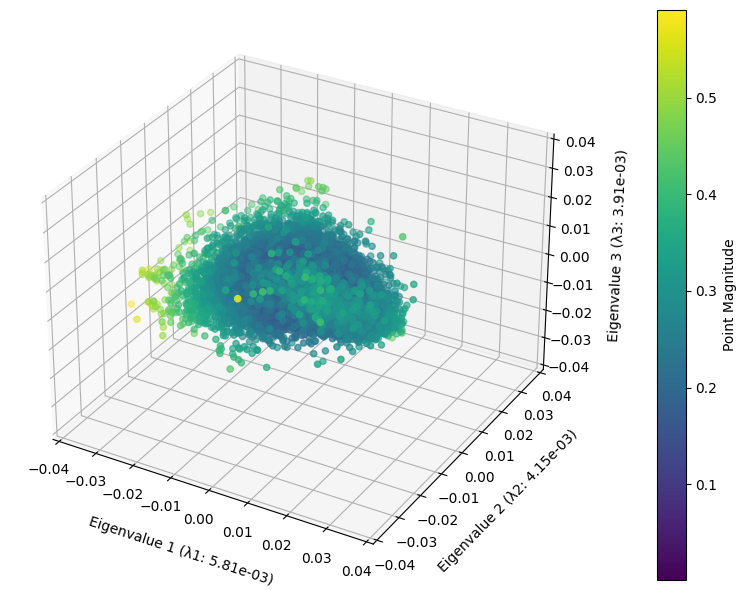

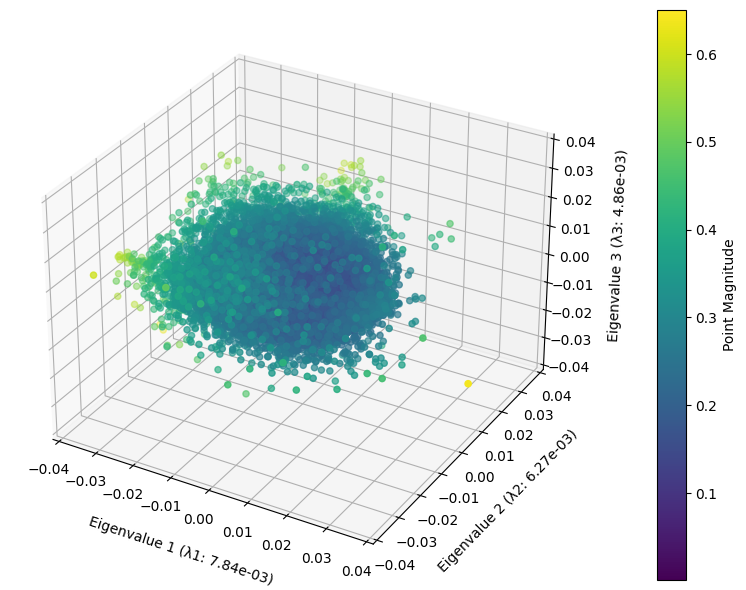

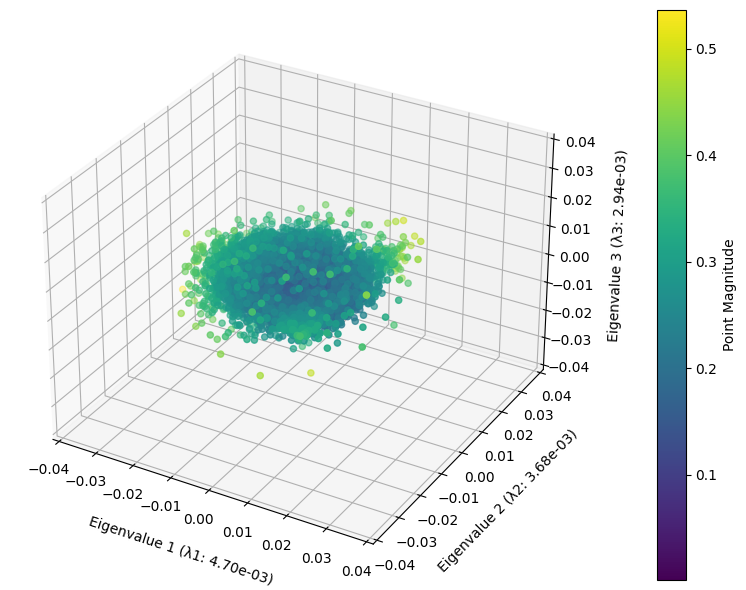

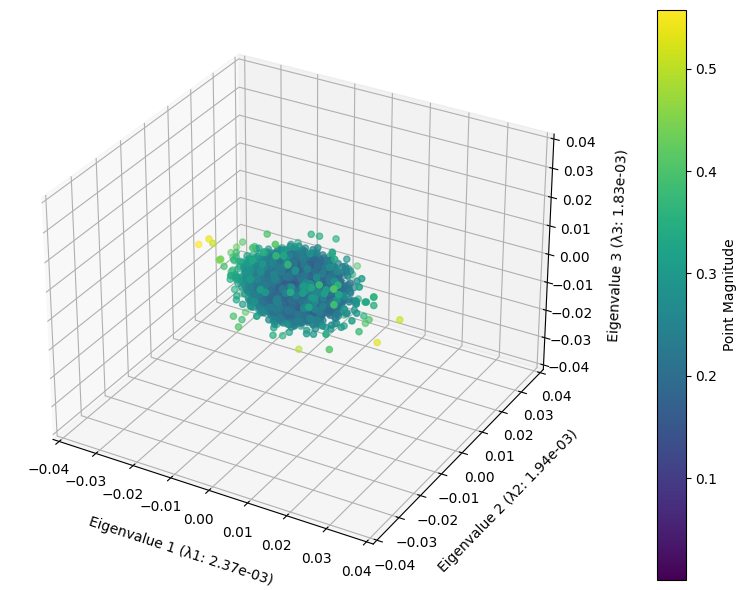

In [ ]:
# Final Version
# Function to calculate and plot the 3D point cloud with fixed axis scaling
def plot_3d_point_cloud_with_fixed_axes(features, layer, eigenvalue_ranges, title_suffix=''):
    pca = PCA(n_components=3)
    transformed_features = pca.fit_transform(features)

    # Eigenvalues of the PCA components
    eigenvalues = pca.explained_variance_

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Normalize point magnitudes for better visualization (optional)
    point_magnitudes = np.linalg.norm(transformed_features, axis=1)

    # Scale the PCA components by their eigenvalues for elongation effect
    scaled_features = transformed_features * np.sqrt(eigenvalues)

    # Plot the points in the scaled PCA space
    sc = ax.scatter(
        scaled_features[:, 0],
        scaled_features[:, 1],
        scaled_features[:, 2],
        c=point_magnitudes, cmap='viridis'
    )

    cbar = plt.colorbar(sc, pad=0.1)
    cbar.set_label('Point Magnitude')

    ax.set_xlabel(f'Eigenvalue 1 (λ1: {eigenvalues[0]:.2e})', labelpad=10)
    ax.set_ylabel(f'Eigenvalue 2 (λ2: {eigenvalues[1]:.2e})', labelpad=10)
    ax.set_zlabel(f'Eigenvalue 3 (λ3: {eigenvalues[2]:.2e})', labelpad=10)

    # Set axis limits based on Layer 12 ranges (eigenvalue_ranges)
    ax.set_xlim(eigenvalue_ranges[0])
    ax.set_ylim(eigenvalue_ranges[1])
    ax.set_zlim(eigenvalue_ranges[2])

    # plt.title(f'3D Point Cloud for Layer {layer} {title_suffix}', pad=20)  # Add padding to the title
    plt.tight_layout()
    plt.show()

# Define the axis ranges based on Layer 12
eigenvalue_ranges = [
    [-0.04, 0.04],  # Range for Eigenvalue 1 (X-axis)
    [-0.04, 0.04],  # Range for Eigenvalue 2 (Y-axis)
    [-0.04, 0.04]   # Range for Eigenvalue 3 (Z-axis)
]

# Main execution
layers_to_analyze = [0, 6, 12, 18, 24]
layer_features_dict = {i: decoding_vectors for i, decoding_vectors in all_decoding_features.items()}
for layer in layers_to_analyze:
    features = layer_features_dict[layer]
    plot_3d_point_cloud_with_fixed_axes(features, layer, eigenvalue_ranges, title_suffix="with Fixed Axis Scaling")


## 3. Log-log Plot of Eigenvalues

Gaussian Fitted Slope: -0.0276
Layer 0 Fitted Slope: -0.2383
Layer 4 Fitted Slope: -0.3161
Layer 8 Fitted Slope: -0.3512
Layer 12 Fitted Slope: -0.4684
Layer 16 Fitted Slope: -0.3622
Layer 20 Fitted Slope: -0.2822
Layer 24 Fitted Slope: -0.2545


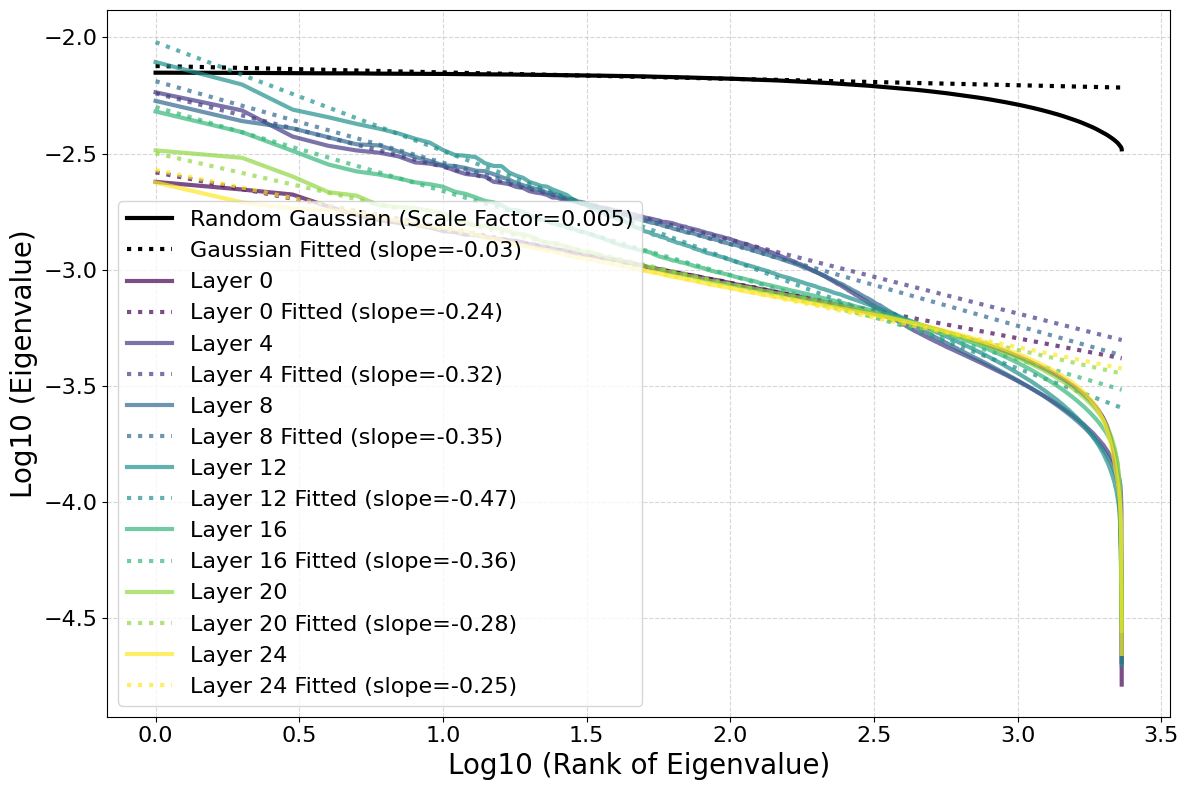

In [ ]:
# Final Version
def generate_random_gaussian_data(num_samples=16000, num_features=600):
    """Generate random Gaussian data."""
    return np.random.normal(0, 1, (num_samples, num_features))

def compute_eigenvalues(data):
    """Compute and return sorted eigenvalues of the covariance matrix."""
    cov_matrix = np.cov(data, rowvar=False)
    eigenvalues = np.linalg.eigvalsh(cov_matrix)
    return np.sort(eigenvalues)[::-1]

def compute_scaling_factor_custom(eigenvalues_layer, eigenvalues_gaussian, method='mean', custom_factor=None):
    """Compute or use a custom scaling factor."""
    if method == 'mean':
        scaling_factor = np.mean(eigenvalues_layer) / np.mean(eigenvalues_gaussian)
    elif method == 'custom' and custom_factor:
        scaling_factor = custom_factor
    else:
        scaling_factor = 1  # No scaling if method is incorrect
    return scaling_factor

def plot_eigenvalue_distributions(layer_features_dict, num_samples=16000, num_features=600, middle_layer=12, custom_scaling_factor=None):
    plt.figure(figsize=(12, 8))

    # Generate and plot Gaussian data eigenvalues
    X_gaussian = generate_random_gaussian_data(num_samples, num_features)
    eigenvalues_gaussian = compute_eigenvalues(X_gaussian)

    # Take the middle layer eigenvalues to compute scaling factor
    if middle_layer not in layer_features_dict:
        print(f"Middle layer {middle_layer} not found in the data. Using another layer.")
        middle_layer = next(iter(layer_features_dict.keys()))

    eigenvalues_layer_example = compute_eigenvalues(layer_features_dict[middle_layer])

    # Compute the scaling factor
    scaling_factor = compute_scaling_factor_custom(eigenvalues_layer_example, eigenvalues_gaussian, method='custom', custom_factor=custom_scaling_factor)
    eigenvalues_gaussian_scaled = eigenvalues_gaussian * scaling_factor

    # Plot scaled Gaussian eigenvalues
    log_x_gaussian = np.log10(np.arange(1, len(eigenvalues_gaussian_scaled) + 1))
    log_y_gaussian = np.log10(eigenvalues_gaussian_scaled)

    plt.plot(log_x_gaussian, log_y_gaussian, label=f'Random Gaussian (Scale Factor={custom_scaling_factor})', color='black', linewidth=3)

    # Fit slope for scaled Gaussian data
    start_index_gaussian, end_index_gaussian = 10, 150
    slope_gaussian, intercept_gaussian, _, _, _ = linregress(log_x_gaussian[start_index_gaussian:end_index_gaussian],
                                                             log_y_gaussian[start_index_gaussian:end_index_gaussian])
    fitted_line_gaussian = intercept_gaussian + slope_gaussian * log_x_gaussian
    plt.plot(log_x_gaussian, fitted_line_gaussian, linestyle=':', color='black', linewidth=3,
             label=f'Gaussian Fitted (slope={slope_gaussian:.2f})')

    print(f"Gaussian Fitted Slope: {slope_gaussian:.4f}")

    # Plot eigenvalues for each layer
    colors = plt.cm.viridis(np.linspace(0, 1, len(layer_features_dict)))
    for (layer, features), color in zip(layer_features_dict.items(), colors):
        eigenvalues = compute_eigenvalues(features)
        log_x = np.log10(np.arange(1, len(eigenvalues) + 1))
        log_y = np.log10(eigenvalues)

        plt.plot(log_x, log_y, label=f'Layer {layer}', color=color, alpha=0.7, linewidth=3)

        # Fit slope
        start_index, end_index = 10, 150
        slope, intercept, _, _, _ = linregress(log_x[start_index:end_index], log_y[start_index:end_index])
        fitted_line = intercept + slope * log_x
        plt.plot(log_x, fitted_line, linestyle=':', color=color, linewidth=3,
                 label=f'Layer {layer} Fitted (slope={slope:.2f})', alpha=0.7)

        print(f"Layer {layer} Fitted Slope: {slope:.4f}")

    plt.xlabel('Log10 (Rank of Eigenvalue)', fontsize=20)
    plt.ylabel('Log10 (Eigenvalue)', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.legend(loc='lower left', fontsize=16)
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


layers_to_analyze = [0, 4, 8, 12, 16, 20, 24]
subset_layer_features_dict = {layer: features for layer, features in all_decoding_features.items() if layer in layers_to_analyze}

# Adjust this scaling factor to bring the Gaussian curve closer to the other curves
custom_scaling_factor = 0.005  # Adjust this factor for better alignment

plot_eigenvalue_distributions(subset_layer_features_dict, num_samples=65536, num_features=2304, middle_layer=12, custom_scaling_factor=custom_scaling_factor)


Gaussian Fitted Slope: -0.0275
Layer 0 Fitted Slope: -0.2383
Layer 4 Fitted Slope: -0.3161
Layer 8 Fitted Slope: -0.3512
Layer 12 Fitted Slope: -0.4684
Layer 16 Fitted Slope: -0.3622
Layer 20 Fitted Slope: -0.2822
Layer 24 Fitted Slope: -0.2545


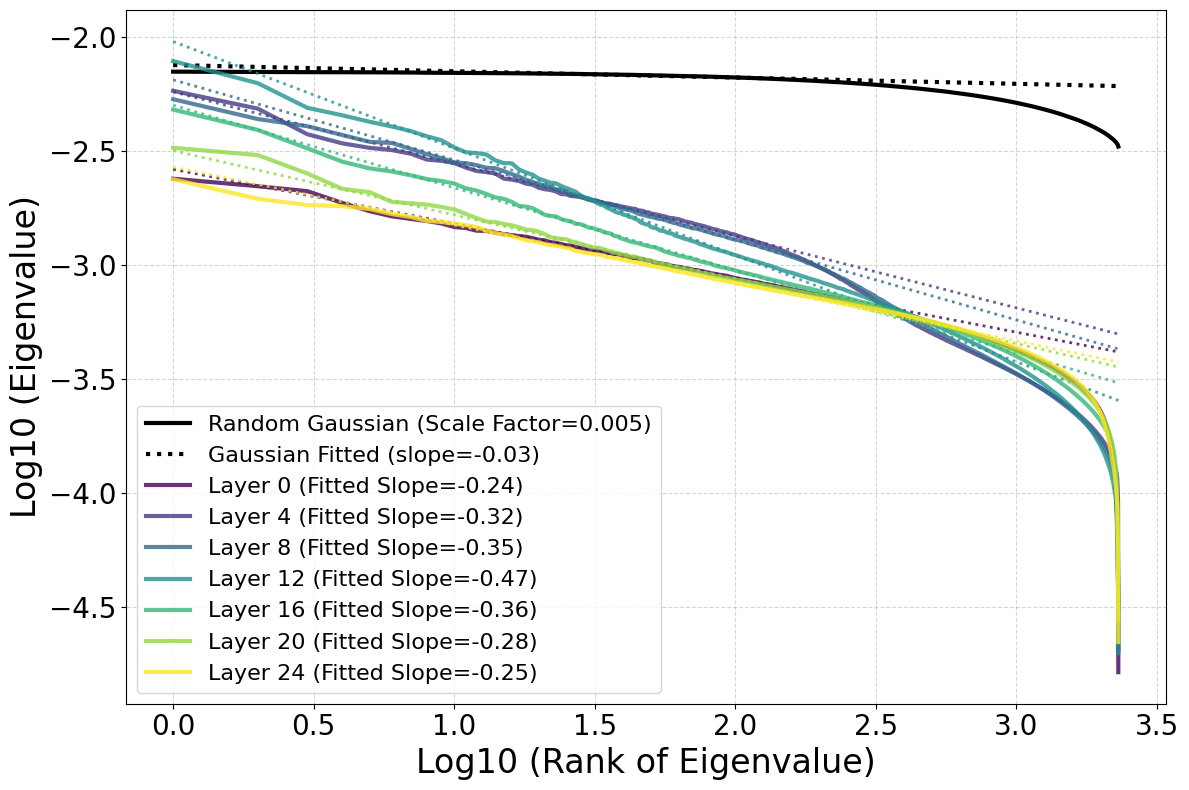

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def generate_random_gaussian_data(num_samples=16000, num_features=600):
    """Generate random Gaussian data."""
    return np.random.normal(0, 1, (num_samples, num_features))

def compute_eigenvalues(data):
    """Compute and return sorted eigenvalues of the covariance matrix."""
    cov_matrix = np.cov(data, rowvar=False)
    eigenvalues = np.linalg.eigvalsh(cov_matrix)
    return np.sort(eigenvalues)[::-1]

def compute_scaling_factor_custom(eigenvalues_layer, eigenvalues_gaussian, method='mean', custom_factor=None):
    """Compute or use a custom scaling factor."""
    if method == 'mean':
        scaling_factor = np.mean(eigenvalues_layer) / np.mean(eigenvalues_gaussian)
    elif method == 'custom' and custom_factor:
        scaling_factor = custom_factor
    else:
        scaling_factor = 1  # No scaling if method is incorrect
    return scaling_factor

def plot_eigenvalue_distributions(layer_features_dict, num_samples=16000, num_features=600, middle_layer=12, custom_scaling_factor=None):
    plt.figure(figsize=(12, 8))

    # Generate and plot Gaussian data eigenvalues
    X_gaussian = generate_random_gaussian_data(num_samples, num_features)
    eigenvalues_gaussian = compute_eigenvalues(X_gaussian)

    # Take the middle layer eigenvalues to compute scaling factor
    if middle_layer not in layer_features_dict:
        print(f"Middle layer {middle_layer} not found in the data. Using another layer.")
        middle_layer = next(iter(layer_features_dict.keys()))

    eigenvalues_layer_example = compute_eigenvalues(layer_features_dict[middle_layer])

    # Compute the scaling factor
    scaling_factor = compute_scaling_factor_custom(eigenvalues_layer_example, eigenvalues_gaussian, method='custom', custom_factor=custom_scaling_factor)
    eigenvalues_gaussian_scaled = eigenvalues_gaussian * scaling_factor

    # Plot scaled Gaussian eigenvalues
    log_x_gaussian = np.log10(np.arange(1, len(eigenvalues_gaussian_scaled) + 1))
    log_y_gaussian = np.log10(eigenvalues_gaussian_scaled)

    plt.plot(log_x_gaussian, log_y_gaussian, label=f'Random Gaussian (Scale Factor={custom_scaling_factor})', color='black', linewidth=3)

    # Fit slope for scaled Gaussian data
    start_index_gaussian, end_index_gaussian = 10, 150
    slope_gaussian, intercept_gaussian, _, _, _ = linregress(log_x_gaussian[start_index_gaussian:end_index_gaussian],
                                                             log_y_gaussian[start_index_gaussian:end_index_gaussian])
    fitted_line_gaussian = intercept_gaussian + slope_gaussian * log_x_gaussian
    plt.plot(log_x_gaussian, fitted_line_gaussian, linestyle=':', color='black', linewidth=3,
             label=f'Gaussian Fitted (slope={slope_gaussian:.2f})')

    print(f"Gaussian Fitted Slope: {slope_gaussian:.4f}")

    # Plot eigenvalues for each layer
    colors = plt.cm.viridis(np.linspace(0, 1, len(layer_features_dict)))
    for (layer, features), color in zip(layer_features_dict.items(), colors):
        eigenvalues = compute_eigenvalues(features)
        log_x = np.log10(np.arange(1, len(eigenvalues) + 1))
        log_y = np.log10(eigenvalues)

        # Fit slope
        start_index, end_index = 10, 150
        slope, intercept, _, _, _ = linregress(log_x[start_index:end_index], log_y[start_index:end_index])
        fitted_line = intercept + slope * log_x

        # Combine layer and fitted slope in the same legend entry
        plt.plot(log_x, log_y, label=f'Layer {layer} (Fitted Slope={slope:.2f})', color=color, alpha=0.8, linewidth=3)

        # Plot fitted line
        plt.plot(log_x, fitted_line, linestyle=':', color=color, linewidth=2, alpha=0.8)

        print(f"Layer {layer} Fitted Slope: {slope:.4f}")

    plt.xlabel('Log10 (Rank of Eigenvalue)', fontsize=24)
    plt.ylabel('Log10 (Eigenvalue)', fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.legend(loc='lower left', fontsize=16)
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

layers_to_analyze = [0, 4, 8, 12, 16, 20, 24]
subset_layer_features_dict = {layer: features for layer, features in all_decoding_features.items() if layer in layers_to_analyze}

# Adjust this scaling factor to bring the Gaussian curve closer to the other curves
custom_scaling_factor = 0.005  # Adjust this factor for better alignment

plot_eigenvalue_distributions(subset_layer_features_dict, num_samples=65536, num_features=2304, middle_layer=12, custom_scaling_factor=custom_scaling_factor)


## 4. Power-law Exponents and Log-determinants

Power-Law Exponents (alphas): [0.23825508593831554, 0.26727330095871693, 0.2667710852960765, 0.2702253147035227, 0.31605557620195923, 0.33723243462622954, 0.3403923260344081, 0.34667936796170296, 0.3511562469555508, 0.3639865852815064, 0.3646799333930443, 0.4631174010955052, 0.4684370198590304, 0.48581242091149074, 0.48092381074118573, 0.37393945395782374, 0.36224018772167765, 0.35934976556357306, 0.3414645624712813, 0.31090078680845973, 0.2822430059523948, 0.2762261514397363, 0.24743660618661234, 0.23211469182419495, 0.25446610203540526, 0.3234880243742205]
Power-Law Exponent Errors (alpha_errors): [0.0012134930168270057, 0.0013564442831636998, 0.0049783457521311554, 0.005753958119315873, 0.003500850286236619, 0.0024907660215575393, 0.002056099163621993, 0.001585761440743573, 0.0018979820749094557, 0.0023628439170649525, 0.0027689008103476695, 0.006114828767361829, 0.006126386244161296, 0.006009627534836609, 0.007219467750281057, 0.003936806903409543, 0.0034708124704828213, 0.00337527

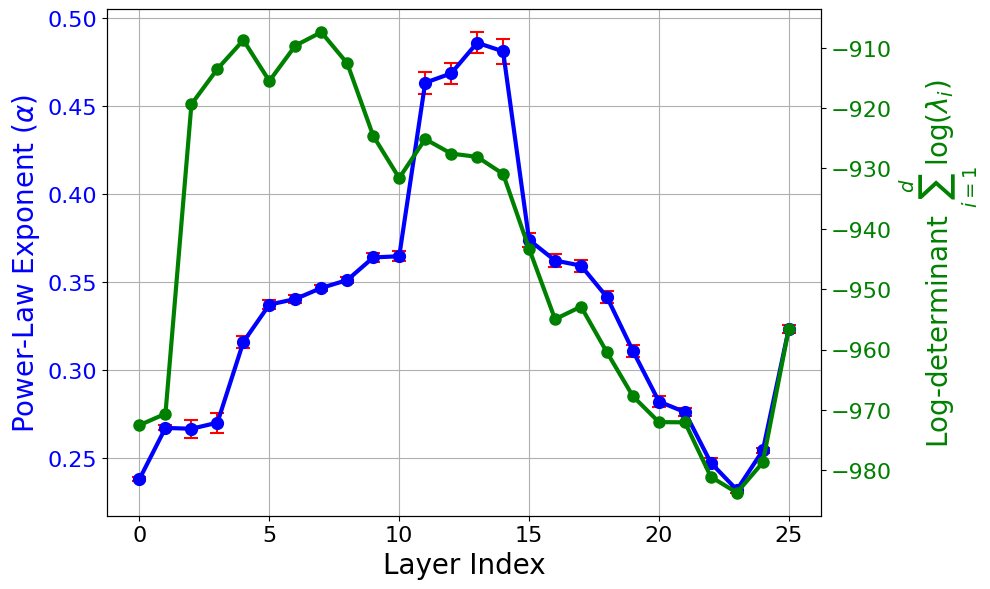

In [ ]:
# Final Version
def compute_eigenvalues(features):
    cov_matrix = np.cov(features, rowvar=False)
    eigenvalues = np.linalg.eigvalsh(cov_matrix)
    eigenvalues = np.sort(eigenvalues)[::-1]
    return eigenvalues

def calculate_alpha_and_logdet_vs_layer(layer_features_dict, start_index=0, end_index=None):
    layers = []
    alphas = []
    alpha_errors = []
    logdet_sums = []

    for layer in sorted(layer_features_dict.keys()):
        features = layer_features_dict[layer]
        eigenvalues = compute_eigenvalues(features)

        # Convert x y axes to log10
        ranks = np.arange(1, len(eigenvalues) + 1)
        log_x = np.log10(ranks)
        log_y = np.log10(eigenvalues)

        # Select the linear region
        if end_index is None:
            end_index = len(eigenvalues)
        linear_region = slice(start_index, end_index)

        # Perform linear regression to get alpha
        slope, intercept, r_value, p_value, std_err = linregress(
            log_x[linear_region], log_y[linear_region]
        )
        alpha = -slope  # Exponent alpha is negative of the slope

        # Compute degrees of freedom for error estimation
        n = len(log_x[linear_region])
        df = n - 2
        t_crit = t.ppf(0.975, df) if df > 0 else np.nan
        alpha_error = t_crit * std_err if df > 0 else np.nan

        # Compute sum of log eigenvalues for log-determinant term (ignore small eigenvalues)
        sum_log_eigenvalues = np.sum(np.log(eigenvalues[start_index:end_index]))

        layers.append(layer)
        alphas.append(alpha)
        alpha_errors.append(alpha_error)
        logdet_sums.append(sum_log_eigenvalues)

    print("Power-Law Exponents (alphas):", alphas)
    print("Power-Law Exponent Errors (alpha_errors):", alpha_errors)
    print("Log-Determinant Sums (logdet_sums):", logdet_sums)

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.errorbar(
        layers, alphas, yerr=alpha_errors, fmt='o-', capsize=5, ecolor='red', linewidth=3, elinewidth=1.5, markeredgewidth=1.5,
        label=r'Power-Law Exponent $(\alpha)$', color='blue', markersize=8
    )
    ax1.set_xlabel('Layer Index', fontsize=20)
    ax1.set_ylabel(r'Power-Law Exponent $(\alpha)$', fontsize=20, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=16)
    ax1.tick_params(axis='x', labelsize=16)
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(layers, logdet_sums, 'o-', color='green', label=r'$\sum_{i=1}^d \log(\lambda_i)$', linewidth=3, markersize=8)
    ax2.set_ylabel(r'Log-determinant $\sum_{i=1}^d \log(\lambda_i)$', fontsize=20, color='green')
    ax2.tick_params(axis='y', labelcolor='green', labelsize=16)  # Enlarged tick labels for secondary y-axis

    fig.tight_layout()
    plt.show()

    return layers, alphas, alpha_errors, logdet_sums

# Main execution
layer_features_dict = {i: decoding_vectors for i, decoding_vectors in all_decoding_features.items()}
layers, alphas, alpha_errors, logdet_sums = calculate_alpha_and_logdet_vs_layer(
    layer_features_dict, start_index=10, end_index=150
)


In [ ]:
def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)

def compute_random_clustering_entropy(n_samples=5000, d=100):
    """Compute clustering entropy for a random Gaussian matrix."""
    random_matrix = np.random.normal(size=(n_samples, d))
    eigenvalues = compute_eigenvalues(random_matrix)
    clustering_entropy = calculate_gaussian_entropy(eigenvalues, d=d)
    return clustering_entropy

def plot_clustering_vs_layer_with_random_entropy(layer_indices, clustering_vals, clustering_errors, random_entropy):
    """Plot clustering entropy with a horizontal line for random entropy."""
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        layer_indices,
        clustering_vals,
        yerr=clustering_errors,
        fmt='o-',
        capsize=5,
        ecolor='red',
        elinewidth=2,
        markeredgewidth=2,
        linewidth=3,
        label='Clustering Entropy',
    )
    # Add horizontal line for random clustering entropy
    plt.axhline(y=random_entropy, color='gray', linestyle='--', linewidth=2, label='Random Matrix Entropy')

    plt.xlabel('Layer Index', fontsize=20)
    plt.ylabel('Clustering Entropy', fontsize=20)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution with random entropy
set_seed()
d = 100  # principal components
k = 1  # nearest neighbors
th = 1e-2  # threshold
n_samples = 5000  # Subsample size

layer_features_dict = {i: decoding_vectors for i, decoding_vectors in all_decoding_features.items()}  # (n_samples, feature_dim)
random_entropy = compute_random_clustering_entropy(n_samples=n_samples, d=d)

# Plot clustering (negentropy) vs. layer with 95% confidence intervals and random entropy
plot_clustering_vs_layer_with_random_entropy(layer_indices, clustering_vals, clustering_errors, random_entropy)


NameError: name 'layer_indices' is not defined

Layer 0: Clustering (Negentropy) = 354.6868, Error = 1.7430
Layer 1: Clustering (Negentropy) = 355.7910, Error = 1.9245
Layer 2: Clustering (Negentropy) = 356.7012, Error = 2.0815
Layer 3: Clustering (Negentropy) = 360.2913, Error = 1.6379
Layer 4: Clustering (Negentropy) = 361.2046, Error = 1.8370
Layer 5: Clustering (Negentropy) = 363.2057, Error = 1.8396
Layer 6: Clustering (Negentropy) = 362.0615, Error = 1.7452
Layer 7: Clustering (Negentropy) = 364.7582, Error = 1.6147
Layer 8: Clustering (Negentropy) = 364.4361, Error = 1.7340
Layer 9: Clustering (Negentropy) = 365.3294, Error = 1.4541
Layer 10: Clustering (Negentropy) = 364.6357, Error = 1.6134
Layer 11: Clustering (Negentropy) = 368.5501, Error = 1.9731
Layer 12: Clustering (Negentropy) = 366.3694, Error = 1.7805
Layer 13: Clustering (Negentropy) = 364.7574, Error = 2.2073
Layer 14: Clustering (Negentropy) = 365.4237, Error = 1.7836
Layer 15: Clustering (Negentropy) = 363.9509, Error = 1.8254
Layer 16: Clustering (Negentropy) 

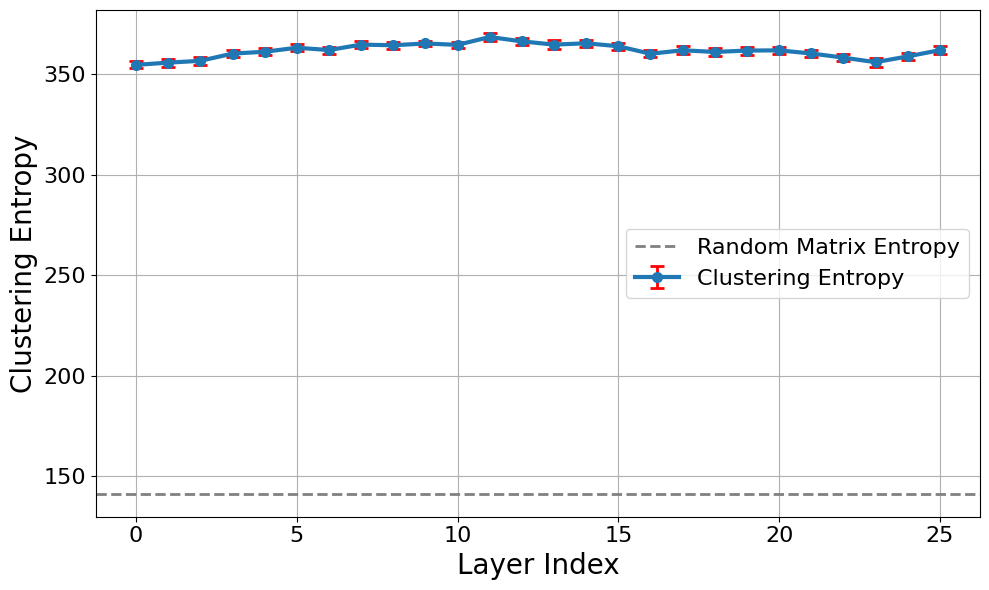

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import t
from sklearn.decomposition import PCA

def set_seed(seed=0):
    """Set random seed for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)

def compute_eigenvalues(features):
    """Compute and return sorted eigenvalues of the covariance matrix."""
    try:
        # Compute covariance matrix
        C = np.cov(features, rowvar=False)
        # Get eigenvalues and ensure positive
        eigenvalues = np.linalg.eigvalsh(C)
        eigenvalues = np.maximum(eigenvalues, 1e-10)
        eigenvalues = np.sort(eigenvalues)[::-1]
        return eigenvalues
    except np.linalg.LinAlgError as e:
        print(f"Error computing eigenvalues: {e}")
        return np.zeros(features.shape[1])

def calculate_gaussian_entropy(eigenvalues, d=100):
    """Calculate the Gaussian entropy for the top d eigenvalues."""
    top_eigenvalues = eigenvalues[:d]
    top_eigenvalues = np.maximum(top_eigenvalues, 1e-10)
    gaussian_entropy = (d / 2) * (1 + np.log(2 * np.pi)) + 0.5 * np.sum(np.log(top_eigenvalues))
    return gaussian_entropy

def compute_random_clustering_entropy(n_samples=5000, d=100):
    """Compute clustering entropy for a random Gaussian matrix."""
    random_matrix = np.random.normal(size=(n_samples, d))
    eigenvalues = compute_eigenvalues(random_matrix)
    clustering_entropy = calculate_gaussian_entropy(eigenvalues, d=d)
    return clustering_entropy

def get_entropy_revised(x, k=1, th=1e-2):
    """Compute entropy using k-nearest neighbors."""
    n = x.shape[0]  # Number of data points
    d = x.shape[1]  # Dimension

    eigenvalues = compute_eigenvalues(x.numpy())
    log_V_eff = np.mean(np.log(eigenvalues[:d]))

    gamma = 0.577216  # Euler-Mascheroni constant
    Psi = -gamma + np.sum(1 / np.arange(1, k + 1))
    H_const = log_V_eff + np.log(n - 1) - Psi

    dist = torch.cdist(x, x, p=2)
    rho = torch.sort(dist, dim=1).values[:, k] + th  # Add threshold
    H_rho = d * torch.mean(torch.log(rho))

    H_total = H_rho + H_const
    return H_total.item()

def compute_clustering_with_error(layer_features_dict, d=100, k=1, th=1e-2, n_samples=10000):
    layer_indices = []
    clustering_vals = []
    clustering_errors = []

    for layer in sorted(layer_features_dict.keys()):
        features = layer_features_dict[layer]

        # Subsample data if necessary for efficiency
        if features.shape[0] > n_samples:
            indices = np.random.choice(features.shape[0], n_samples, replace=False)
            features = features[indices]

        # Standardize features
        features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

        # Dimensionality reduction
        pca = PCA(n_components=d)
        features_pca = pca.fit_transform(features)
        x = torch.tensor(features_pca, dtype=torch.float32)

        # Bootstrapping to estimate error
        bootstrap_samples = 30
        entropy_vals = []

        for _ in range(bootstrap_samples):
            resample_indices = np.random.choice(x.shape[0], x.shape[0], replace=True)
            resample_x = x[resample_indices]
            entropy_vals.append(get_entropy_revised(resample_x, k=k, th=th))

        entropy_mean = np.mean(entropy_vals)
        entropy_std_err = np.std(entropy_vals, ddof=1) / np.sqrt(len(entropy_vals))  # Standard error

        # Compute Gaussian entropy for the top d principal components
        eigenvalues = compute_eigenvalues(features_pca)
        H_gauss = calculate_gaussian_entropy(eigenvalues, d=d)

        # Clustering (negentropy) is H_gauss - entropy_mean
        clustering_val = H_gauss - entropy_mean
        clustering_vals.append(clustering_val)

        # 95% confidence interval using t-distribution
        df = bootstrap_samples - 1
        t_crit = t.ppf(0.975, df)  # 95% confidence
        clustering_error = t_crit * entropy_std_err
        clustering_errors.append(clustering_error)

        layer_indices.append(layer)
        print(f"Layer {layer}: Clustering (Negentropy) = {clustering_val:.4f}, Error = {clustering_error:.4f}")

    return layer_indices, clustering_vals, clustering_errors

def plot_clustering_vs_layer_with_random_entropy(layer_indices, clustering_vals, clustering_errors, random_entropy):
    """Plot clustering entropy with a horizontal line for random entropy."""
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        layer_indices,
        clustering_vals,
        yerr=clustering_errors,
        fmt='o-',
        capsize=5,
        ecolor='red',
        elinewidth=2,
        markeredgewidth=2,
        linewidth=3,
        label='Clustering Entropy',
    )
    # Add horizontal line for random clustering entropy
    plt.axhline(y=random_entropy, color='gray', linestyle='--', linewidth=2, label='Random Matrix Entropy')

    plt.xlabel('Layer Index', fontsize=20)
    plt.ylabel('Clustering Entropy', fontsize=20)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
set_seed()
d = 100  # principal components
k = 1  # nearest neighbors
th = 1e-2  # threshold
n_samples = 5000  # Subsample size

layer_features_dict = {i: decoding_vectors for i, decoding_vectors in all_decoding_features.items()}  # (n_samples, feature_dim)

# Compute clustering entropy and errors
layer_indices, clustering_vals, clustering_errors = compute_clustering_with_error(
    layer_features_dict,
    d=d,
    k=k,
    th=th,
    n_samples=n_samples,
)

# Compute random entropy
random_entropy = compute_random_clustering_entropy(n_samples=n_samples, d=d)

# Plot clustering (negentropy) vs. layer with 95% confidence intervals and random entropy
plot_clustering_vs_layer_with_random_entropy(layer_indices, clustering_vals, clustering_errors, random_entropy)


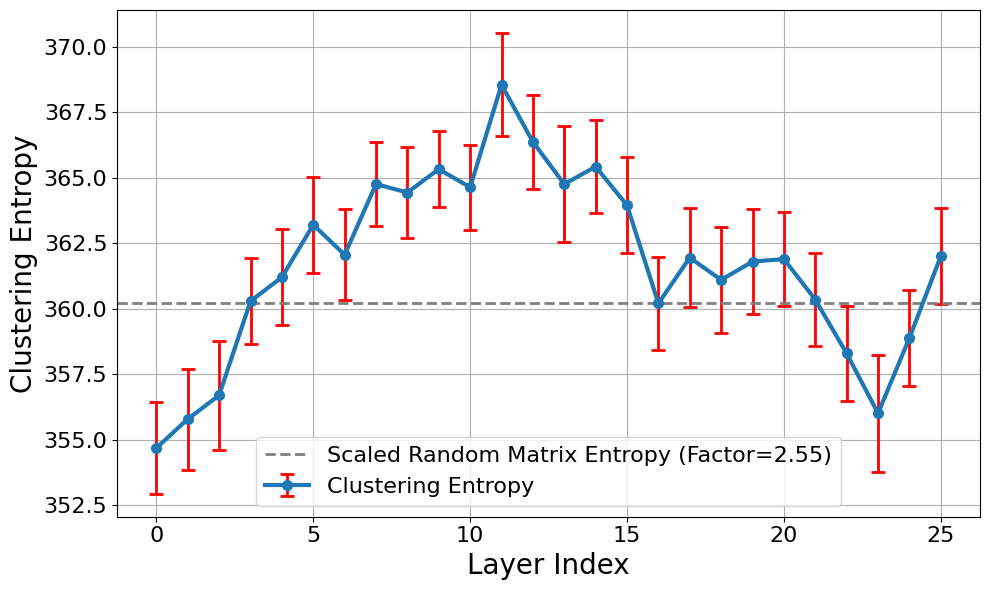

In [ ]:
def compute_scaled_random_clustering_entropy(n_samples=5000, d=100, scaling_factor=1.0):
    """Compute scaled clustering entropy for a random Gaussian matrix."""
    random_matrix = np.random.normal(size=(n_samples, d))
    eigenvalues = compute_eigenvalues(random_matrix)
    random_entropy = calculate_gaussian_entropy(eigenvalues, d=d)
    return random_entropy * scaling_factor

def plot_clustering_vs_layer_with_scaled_random_entropy(
    layer_indices, clustering_vals, clustering_errors, random_entropy, scaling_factor
):
    """Plot clustering entropy with a scaled horizontal line for random entropy."""
    scaled_random_entropy = random_entropy * scaling_factor

    plt.figure(figsize=(10, 6))
    plt.errorbar(
        layer_indices,
        clustering_vals,
        yerr=clustering_errors,
        fmt='o-',
        capsize=5,
        ecolor='red',
        elinewidth=2,
        markeredgewidth=2,
        linewidth=3,
        label='Clustering Entropy',
    )
    # Add scaled horizontal line for random clustering entropy
    plt.axhline(
        y=scaled_random_entropy, color='gray', linestyle='--', linewidth=2, label=f'Scaled Random Matrix Entropy (Factor={scaling_factor})'
    )

    plt.xlabel('Layer Index', fontsize=20)
    plt.ylabel('Clustering Entropy', fontsize=20)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
scaling_factor = 2.55  # Adjust this factor to align the random entropy with clustering entropy

# Compute scaled random entropy
scaled_random_entropy = compute_scaled_random_clustering_entropy(
    n_samples=n_samples, d=d, scaling_factor=scaling_factor
)

# Plot clustering entropy with scaled random entropy
plot_clustering_vs_layer_with_scaled_random_entropy(
    layer_indices, clustering_vals, clustering_errors, random_entropy, scaling_factor
)
